### Load Data 


pacakage to install
- pandas
- scikit-learn
- imblearn

In [2]:
import pandas as pd
import numpy as np

data_df = pd.read_csv("../data/parsed_data.csv")

print(data_df.head())


     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0                122.0     

In [3]:
## load label df
def label_parsing(file_path):
    data = []
    with open(file_path, 'r') as f:
        # first line is variable names
        var_name = f.readline()
        for line in f:
            gene_id, transcript_id, position, label = line.strip().split(',')
            data.append({
                'gene_id': gene_id,
                'transcript_id': transcript_id,
                'position': int(position),
                'label': int(label)
            })
    return pd.DataFrame(data, columns=['gene_id', 'transcript_id', 'position', 'label'])

label_df = label_parsing("../data/data.info.labelled")

print(label_df.head())

           gene_id    transcript_id  position  label
0  ENSG00000004059  ENST00000000233       244      0
1  ENSG00000004059  ENST00000000233       261      0
2  ENSG00000004059  ENST00000000233       316      0
3  ENSG00000004059  ENST00000000233       332      0
4  ENSG00000004059  ENST00000000233       368      0


### Train test split


In [4]:
from sklearn.model_selection import train_test_split
unique_genes = label_df['gene_id'].unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.2, random_state=49)
train_transcript = label_df[label_df['gene_id'].isin(train_genes)]["transcript_id"]
test_transcript = label_df[label_df['gene_id'].isin(test_genes)]["transcript_id"]
train_df = data_df[data_df['transcript_id'].isin(train_transcript)]
test_df = data_df[data_df['transcript_id'].isin(test_transcript)]
print(train_df.head())
print(test_df.head())
print(len(train_df))
print(len(test_df))

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0                122.0     

In [5]:
## add the y label to df
train_df = pd.merge(train_df, label_df[['transcript_id', 'position', 'label']], 
                     on=['transcript_id', 'position'], 
                     how='left')
test_df = pd.merge(test_df, label_df[['transcript_id', 'position', 'label']], 
                     on=['transcript_id', 'position'], 
                     how='left')

# Display the merged dataframe
print(train_df.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  \
0                122.0    

### Oversampling

I use random oversampling here instead of SMOTE because it could generate synthetic transcript IDs and positions, which are not valid.


In [6]:
## find average of each position

averaged_train_df = train_df.groupby(['transcript_id', 'position','flanking_nucleotide']).mean().reset_index()

# Display the resulting DataFrame
print(averaged_train_df.head())

print(len(averaged_train_df))


     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA            0.008264   
1  ENST00000000233       261             CAAACTG            0.006609   
2  ENST00000000233       316             GAAACAG            0.007570   
3  ENST00000000233       332             AGAACAT            0.010620   
4  ENST00000000233       368             AGGACAA            0.010701   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0      4.223784        123.702703               0.009373         7.382162   
1      3.216424        109.681395               0.006813         3.226535   
2      2.940541        105.475676               0.007416         3.642703   
3      6.476350        129.355000               0.008632         2.899200   
4      6.415051        117.924242               0.011479         5.870303   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  \
0           125.913514    

In [7]:
from imblearn.over_sampling import RandomOverSampler

X = averaged_train_df.drop('label', axis=1)  # Features
y = averaged_train_df['label']               # Target (label)

# Define the oversampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the resampled features and labels into a new DataFrame
resampled_train_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

# Display the new shape of the resampled dataset
print(len(resampled_train_df))



9304


### Feature Engineering

#### Normalization

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

numeric_columns = ['dwelling_time_(-1)', 'std_dev_(-1)', 'mean_signal_(-1)',
                   'dwelling_time_central', 'std_dev_central', 'mean_signal_central',
                   'dwelling_time_(+1)', 'std_dev_(+1)', 'mean_signal_(+1)']

# Apply standardization to the numeric columns
standardized_train_df = resampled_train_df.copy()
standardized_train_df[numeric_columns] = scaler.fit_transform(resampled_train_df[numeric_columns])
standardized_test_df = test_df.copy()
standardized_test_df[numeric_columns] = scaler.fit_transform(test_df[numeric_columns])

# View the standardized dataset
print(standardized_test_df.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000002165        35             AGGACAG            0.587867   
1  ENST00000002165        35             AGGACAG            4.318824   
2  ENST00000002165        35             AGGACAG            0.643277   
3  ENST00000002165        35             AGGACAG            0.403166   
4  ENST00000002165        35             AGGACAG            0.532457   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0      1.216909          0.207109               0.507504         0.259188   
1      0.633939          0.383721               0.006674         1.060841   
2      1.126920          0.118803              -0.484882        -0.310661   
3      1.166046          0.472027              -0.486737         0.523187   
4      1.615989          0.560333              -0.423669        -0.404026   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  \
0             0.486517    

maybe can add pca?

In [9]:
standardized_test_df = standardized_test_df.dropna()

### Logistic Regression


In [20]:
'''' 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


X_train = standardized_train_df.drop('label', axis=1)  # Features
y_train = standardized_train_df['label'] 
X_test = standardized_test_df.drop('label', axis=1)  # Features
y_test = standardized_test_df['label']        

LogisticRegression.fit(X_train, y_train)


# Make predictions on the test set
y_pred = log_reg.predict(X_test)

'''

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Initialize LabelEncoder for 'transcript_id'
le = LabelEncoder()

'''
# Encode the 'transcript_id' as numerical values
standardized_train_df['transcript_id_encoded'] = le.fit_transform(standardized_train_df['transcript_id'])
standardized_test_df['transcript_id_encoded'] = le.fit_transform(standardized_test_df['transcript_id'])
'''

# Select numeric columns for training, including 'position'
# Drop 'transcript_id' (as it's now encoded) and 'flanking_nucleotide' (if not needed)
X_train_label = standardized_train_df[['transcript_id', 'position','flanking_nucleotide']]
X_train = standardized_train_df.drop(columns=['transcript_id', 'flanking_nucleotide','label'])
y_train = standardized_train_df['label'] 
X_test_label = standardized_test_df[['transcript_id', 'position','flanking_nucleotide']]
X_test = standardized_test_df.drop(columns=['transcript_id', 'flanking_nucleotide','label'])
y_test = standardized_test_df['label']


# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict_proba(X_test)[:,1]



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
print(len(X_test_label))
print(len(y_pred))

145063
145063


In [23]:
print(X_test_label['position'][:100])

0     35
1     35
2     35
3     35
4     35
      ..
95    54
96    54
97    54
98    54
99    54
Name: position, Length: 100, dtype: int64


In [24]:
# Add probabilities to the dataframe
results = X_test_label.copy()
results['probabilities'] = y_pred
print(results.head())

     transcript_id  position flanking_nucleotide  probabilities
0  ENST00000002165        35             AGGACAG       0.539107
1  ENST00000002165        35             AGGACAG       0.700210
2  ENST00000002165        35             AGGACAG       0.787666
3  ENST00000002165        35             AGGACAG       0.776676
4  ENST00000002165        35             AGGACAG       0.868113


In [28]:
results = results.groupby(['transcript_id', 'position','flanking_nucleotide']).mean().reset_index()


In [30]:
print(results.head())
print(len(results))

     transcript_id  position flanking_nucleotide  probabilities
0  ENST00000001008       190             ATGACAG       0.262601
1  ENST00000001008       257             TGGACAT       0.541841
2  ENST00000001008       270             CAAACAG       0.210099
3  ENST00000001008       338             GGGACCG       0.704600
4  ENST00000001008       389             TTGACTC       0.492757
1283


Accuracy: 0.5310795998979754
AUC: 0.704132725318472


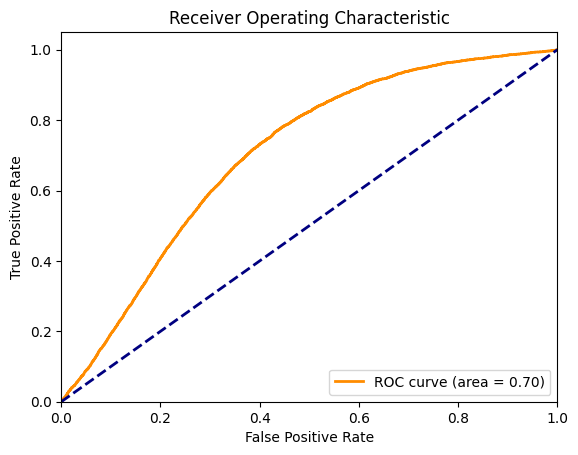

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

y_pred_class = (y_pred >= 0.5).astype(int)

# Step 4: Measure accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)

# Step 5: Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Step 6: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
